In [1]:

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from helper.model_plots import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.patches import Circle


In [2]:

days = pd.read_parquet('data/daily.parquet',engine='fastparquet')
labeled_users = pd.read_parquet('data/labeled_users.parquet',engine='fastparquet')
bets = pd.read_parquet('data/bets.parquet',engine='fastparquet')


In [3]:
labeled_users.groupby('cluster_label').size()


cluster_label
0    25746
1     1957
2      413
3     3442
4      456
5       88
dtype: int64

In [4]:
target_cluster_users = labeled_users[labeled_users['cluster_label'] == 0]['user_id'].to_list()
target_cluster_users[:5]


[44, 46, 5977, 7612, 9388]

In [54]:
target_cluster_users_days = days[days['user_id'].isin(target_cluster_users)]
target_cluster_users_days.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970


In [55]:
target_cluster_users_days.columns


Index(['user_id', 'day_of_year', 'odds_log_mean', 'odds_log_std',
       'bet_prop_log_mean', 'bet_prop_log_std', 'n_sessions', 'n_active_hours',
       'bet_top1hour%', 'bet_top2hours%', 'bet_top4hours%', 'slope_bet_day',
       'slope_odd_day', 'n_bet_proportion'],
      dtype='object')

In [56]:
target_days = target_cluster_users_days.drop(columns=['user_id','day_of_year'])
target_days.head()


,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(target_days)
X_scaled[0]

# original_X = scaler.inverse_transform(X_scaled)
# original_X[0]


array([-1.3602558 , -0.96073425,  0.37522426, -0.72563059, -0.41711495,
        0.37676417, -2.63472111,  0.19281784,  0.19281784,  0.00539622,
        0.02893782, -0.12624421])

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [24]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, intermediate_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [45]:
def train_and_score_one_ae(X_scaled, device, n_epochs=50, batch_size=64, lr=1e-3, encoding_dim=4, intermediate_dim=8):
    
    input_dim = X_scaled.shape[1]

    model = Autoencoder(input_dim, intermediate_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    tensor_x = torch.tensor(X_scaled, dtype=torch.float32)
    dataset = TensorDataset(tensor_x) 
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        for (batch,) in loader:
            batch = batch.to(device)

            optimizer.zero_grad()
            recon = model(batch)
            loss = criterion(recon, batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.size(0)

        epoch_loss /= len(dataset)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.6f}")
        
        
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        X_recon = model(X_tensor).cpu().numpy()
        
    recon_error = ((X_scaled - X_recon) ** 2).mean(axis=1)
        
    print(recon_error.mean(), recon_error.sum())
    print(np.percentile(recon_error, [50, 80, 90, 95, 99]))
    
    return model, recon_error
        



In [84]:
K = 7  # número de autoencoders no ensemble

all_errors = []
models = []

for k in range(K):
    model_k, err_k = train_and_score_one_ae(
        X_scaled=X_scaled,
        device=device,
        n_epochs=50,
        batch_size=64,
        lr=1e-3,
        encoding_dim=4,
        intermediate_dim=8
    )
    models.append(model_k)
    all_errors.append(err_k)



Epoch 1/50 - Loss: 0.591559
Epoch 2/50 - Loss: 0.366266
Epoch 3/50 - Loss: 0.302456
Epoch 4/50 - Loss: 0.268182
Epoch 5/50 - Loss: 0.251050
Epoch 6/50 - Loss: 0.243320
Epoch 7/50 - Loss: 0.239083
Epoch 8/50 - Loss: 0.236799
Epoch 9/50 - Loss: 0.235115
Epoch 10/50 - Loss: 0.233833
Epoch 11/50 - Loss: 0.232682
Epoch 12/50 - Loss: 0.231052
Epoch 13/50 - Loss: 0.229997
Epoch 14/50 - Loss: 0.227838
Epoch 15/50 - Loss: 0.225222
Epoch 16/50 - Loss: 0.222984
Epoch 17/50 - Loss: 0.220213
Epoch 18/50 - Loss: 0.216509
Epoch 19/50 - Loss: 0.213902
Epoch 20/50 - Loss: 0.210220
Epoch 21/50 - Loss: 0.207772
Epoch 22/50 - Loss: 0.205128
Epoch 23/50 - Loss: 0.203649
Epoch 24/50 - Loss: 0.201930
Epoch 25/50 - Loss: 0.200523
Epoch 26/50 - Loss: 0.199443
Epoch 27/50 - Loss: 0.198280
Epoch 28/50 - Loss: 0.197589
Epoch 29/50 - Loss: 0.196782
Epoch 30/50 - Loss: 0.195957
Epoch 31/50 - Loss: 0.195280
Epoch 32/50 - Loss: 0.194485
Epoch 33/50 - Loss: 0.193437
Epoch 34/50 - Loss: 0.192569
Epoch 35/50 - Loss: 0.1

In [86]:

all_errors = np.stack(all_errors, axis=0)      # shape: (K, n_samples)


In [ ]:
q1 = np.percentile(all_errors, 25, axis=0)
q3 = np.percentile(all_errors, 75, axis=0)
iqr = q3 - q1


In [90]:

ensemble_error = np.median(all_errors, axis=0) # shape: (n_samples,)


In [91]:
len(all_errors[0])


71316

In [92]:
ensemble_error.mean(), ensemble_error.sum()


(0.15711048279102044, 11204.491190724413)

In [93]:
np.percentile(ensemble_error, [50, 80, 90, 95, 99])


array([0.02603051, 0.17998423, 0.34387713, 0.56526187, 1.59342803])

In [94]:
a = [0.02603051, 0.17998423, 0.34387713, 0.56526187, 1.59342803]


In [95]:
# import numpy as np
a_sqrt = np.sqrt(a)
a_sqrt


array([0.16133973, 0.42424548, 0.58641038, 0.75183899, 1.26231059])

In [96]:
recon_target = target_cluster_users_days.copy()
recon_target["recon_error"] = ensemble_error
recon_target["iqr"] = iqr
recon_target.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,iqr
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000,0.363683,0.202345
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667,0.061066,0.015685
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500,0.008915,0.007589
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282,0.398369,0.102533
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970,0.160427,0.021739


In [97]:
user_errors = recon_target.groupby('user_id')['recon_error'].agg(['mean','count','std'])
user_errors[(user_errors['mean']>0) & (user_errors['count']>1)].sort_values('mean',ascending=False).head(10)


C:\Users\mathe\AppData\Local\Temp\ipykernel_3152\2259087712.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_errors = recon_target.groupby('user_id')['recon_error'].agg(['mean','count','std'])


,mean,count,std
user_id,,,
1455047,9.327757,2,4.427289
1343144,8.488144,22,21.702755
794521,6.896784,3,1.635206
1249661,6.493067,7,16.564088
1357121,6.207878,20,6.944704
1499198,5.561049,2,5.161321
1251347,5.504113,7,12.648238
1446383,5.204372,2,7.339488
1232083,5.157635,6,12.437258


In [ ]:
recon_target


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,iqr
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000,0.363683,0.202345
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667,0.061066,0.015685
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500,0.008915,0.007589
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282,0.398369,0.102533
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970,0.160427,0.021739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130639,1503508,274,0.469348,0.309348,1.480713,2.308513,1.0,1,1.000000,1.000000,1.000000,-0.042490,-0.013468,1.000000,0.005639,0.005369
130640,1503513,274,0.192760,0.105671,2.745244,2.152429,1.0,1,1.000000,1.000000,1.000000,-0.064454,-0.004526,1.000000,0.008782,0.026397
130641,1503516,274,0.386987,0.334752,-8.095021,10.176622,1.0,1,1.000000,1.000000,1.000000,0.095029,-0.004543,1.000000,0.056065,0.187041
130642,1503542,274,0.165514,0.000000,0.000000,0.000000,1.0,1,1.000000,1.000000,1.000000,0.000000,-0.000648,1.000000,0.005566,0.001964


In [130]:
recon_renamed = recon_target.rename(columns={'recon_error':'Erro de reconstrução',
                             'n_active_hours':'Número de horas ativas',
                             'n_sessions':'Número de sessões',
                             'n_bet_proportion':'Proporção do número de apostas',
                             'slope_bet_day':'Inclinação da quantidade de apostas',
                             'slope_odd_day':'Inclinação das odds',
                             'odds_log_mean':'Média do log das odds',
                             'iqr':'Dispersão interquartil do erro',
                             'bet_prop_log_mean':'Média do log das apostas',
                            #  'bet_prop_log_std':'Desvio Padrão do log das apostas',
                            #  'odds_log_std':'Desvio Padrão do log das odds',
                             'bet_top1hour%':'Proporção da hora de maior concentração',
                             })


In [131]:
user_id = 1343144


In [132]:
daily_feats = [
    'Erro de reconstrução',
    'Dispersão interquartil do erro',
    'Média do log das odds', 
    # 'Desvio Padrão do log das odds', 
    'Média do log das apostas',
    # 'Desvio Padrão do log das apostas', 
    'Número de sessões', 'Número de horas ativas', 
    'Inclinação da quantidade de apostas', 'Inclinação das odds', 'Proporção do número de apostas','Proporção da hora de maior concentração'
]


In [251]:
def plot_user_daily(
    df_daily: pd.DataFrame,
    user_id,
    features: list,
    date_col: str = "day_of_year",
    user_col: str = "user_id",
    path_to_save: str = None,
    threshold: float = None,
):
    tmp = df_daily[df_daily[user_col] == user_id].copy()
    if tmp.empty:
        raise ValueError(f"Usuário {user_id} não encontrado no df diário.")

    tmp = tmp.sort_values(date_col)
    tmp[date_col] = tmp[date_col].astype(str) 

    n_feats = len(features)

    ncols = 2
    nrows = math.ceil(n_feats / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(12, 3 * nrows)
    )

    axes = np.array(axes).reshape(-1)
    x = tmp[date_col]

    letters = [chr(ord("A") + i) for i in range(n_feats)]

    for i, (ax, feat) in enumerate(zip(axes, features)):
        if feat not in tmp.columns:
            ax.set_visible(False)
            continue

        ax.plot(
            x,
            tmp[feat],
            marker="o",
            linewidth=1.5,
            alpha=1
        )

        ax.set_title(f"{letters[i]}) {feat}", loc="left")
        ax.set_xlabel("dia")
        ax.set_ylabel(feat)
        ax.tick_params(axis="x", rotation=45)

        ax.grid(True, linestyle="--", alpha=0.3)

        mean_val = tmp[feat].mean()

        if i == 0:
            ax.axhline(
                mean_val,
                linestyle="--",
                color="gray",
                linewidth=1,
                alpha=0.6,
                label="média do usuário"
            )
        else:
            ax.axhline(
                mean_val,
                linestyle="--",
                color="gray",
                linewidth=1,
                alpha=0.6
            )

        if threshold is not None and i == 0:
            ax.axhline(
                threshold,
                linestyle="--",
                color="red",
                linewidth=1,
                alpha=0.6,
                label="limiar de atipicidade"
            )

        if i == 0:
            ax.legend(loc="upper left")
            for ax in axes[n_feats:]:
                ax.set_visible(False)

    # fig.suptitle(
    #     f"Histórico diário — usuário {user_id}",
    #     fontsize=14,
    #     y=1.02
    # )

    plt.tight_layout()

    if path_to_save:
        plt.savefig(path_to_save, dpi=200, bbox_inches="tight")

    plt.show()


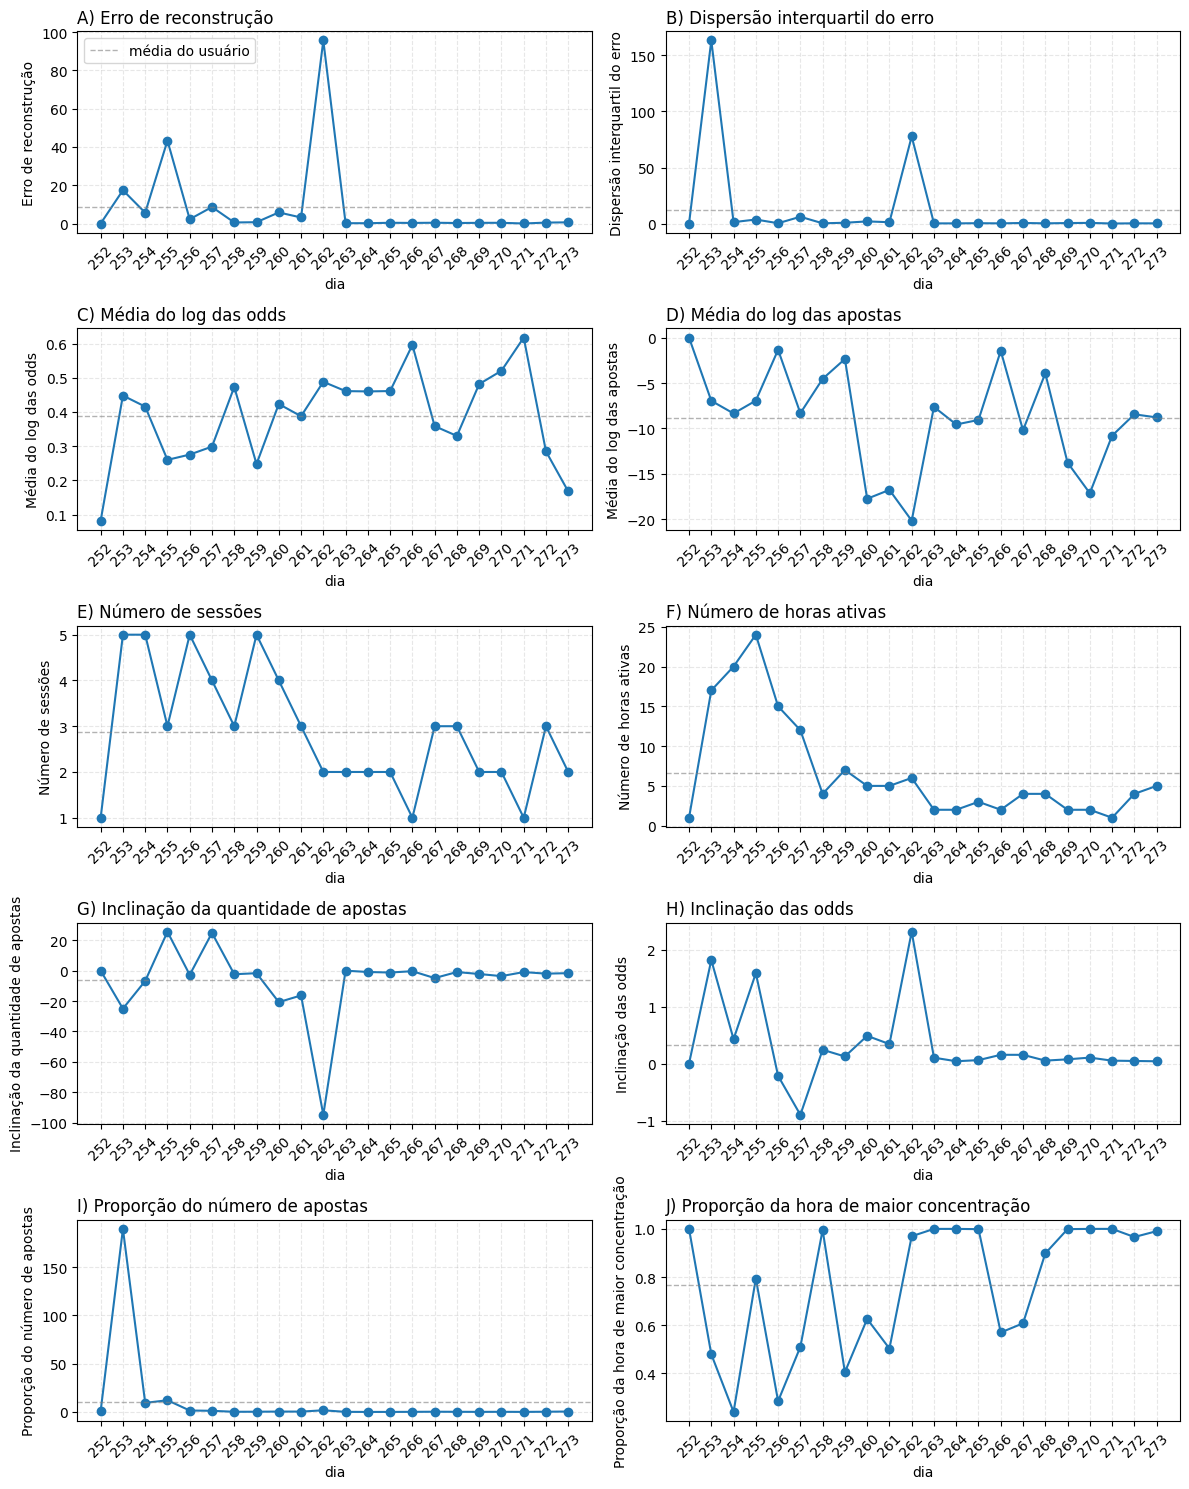

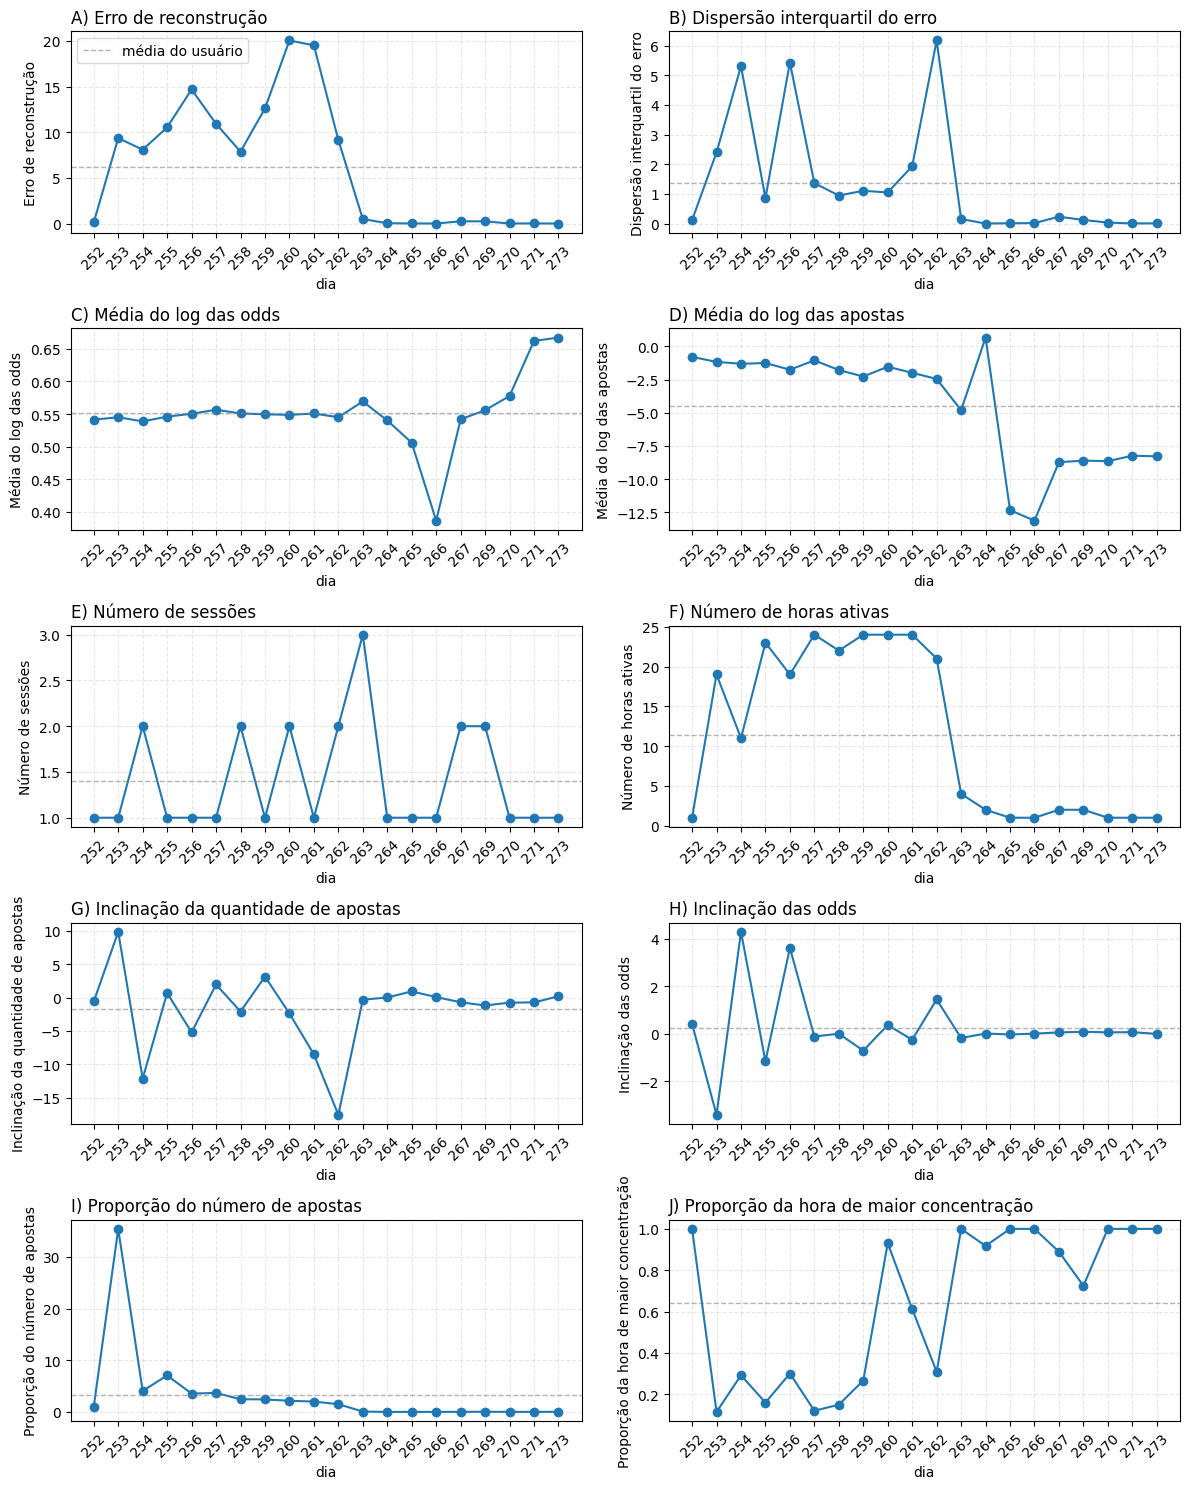

In [261]:
user_id = 1343144
plot_user_daily(recon_renamed, user_id=user_id, features=daily_feats, path_to_save=f'figs/user_{user_id}.pdf')

user_id = 1357121
plot_user_daily(recon_renamed, user_id=user_id, features=daily_feats, path_to_save=f'figs/user_{user_id}.pdf')


In [156]:
user_errors = recon_target.groupby('user_id')['recon_error'].agg(['mean','count'])
user_errors = user_errors[(user_errors['mean']>0) & (user_errors['count']>1)].sort_values('mean',ascending=False)


C:\Users\mathe\AppData\Local\Temp\ipykernel_3152\2226945625.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_errors = recon_target.groupby('user_id')['recon_error'].agg(['mean','count'])


In [157]:
ancor = np.percentile(user_errors['mean'],80)
user_errors["dist"] = (user_errors["mean"] - ancor).abs()


In [158]:
user_errors.sort_values(by='dist', ascending=True).head(10)


,mean,count,dist
user_id,,,
1432639,0.190598,2,0.000012
1495917,0.190660,2,0.000050
1234049,0.190508,6,0.000102
1319390,0.190503,4,0.000108
1046423,0.190480,12,0.000130
1466890,0.190469,5,0.000142
1368656,0.190455,9,0.000155
1369502,0.190807,2,0.000197
1448370,0.190374,2,0.000237


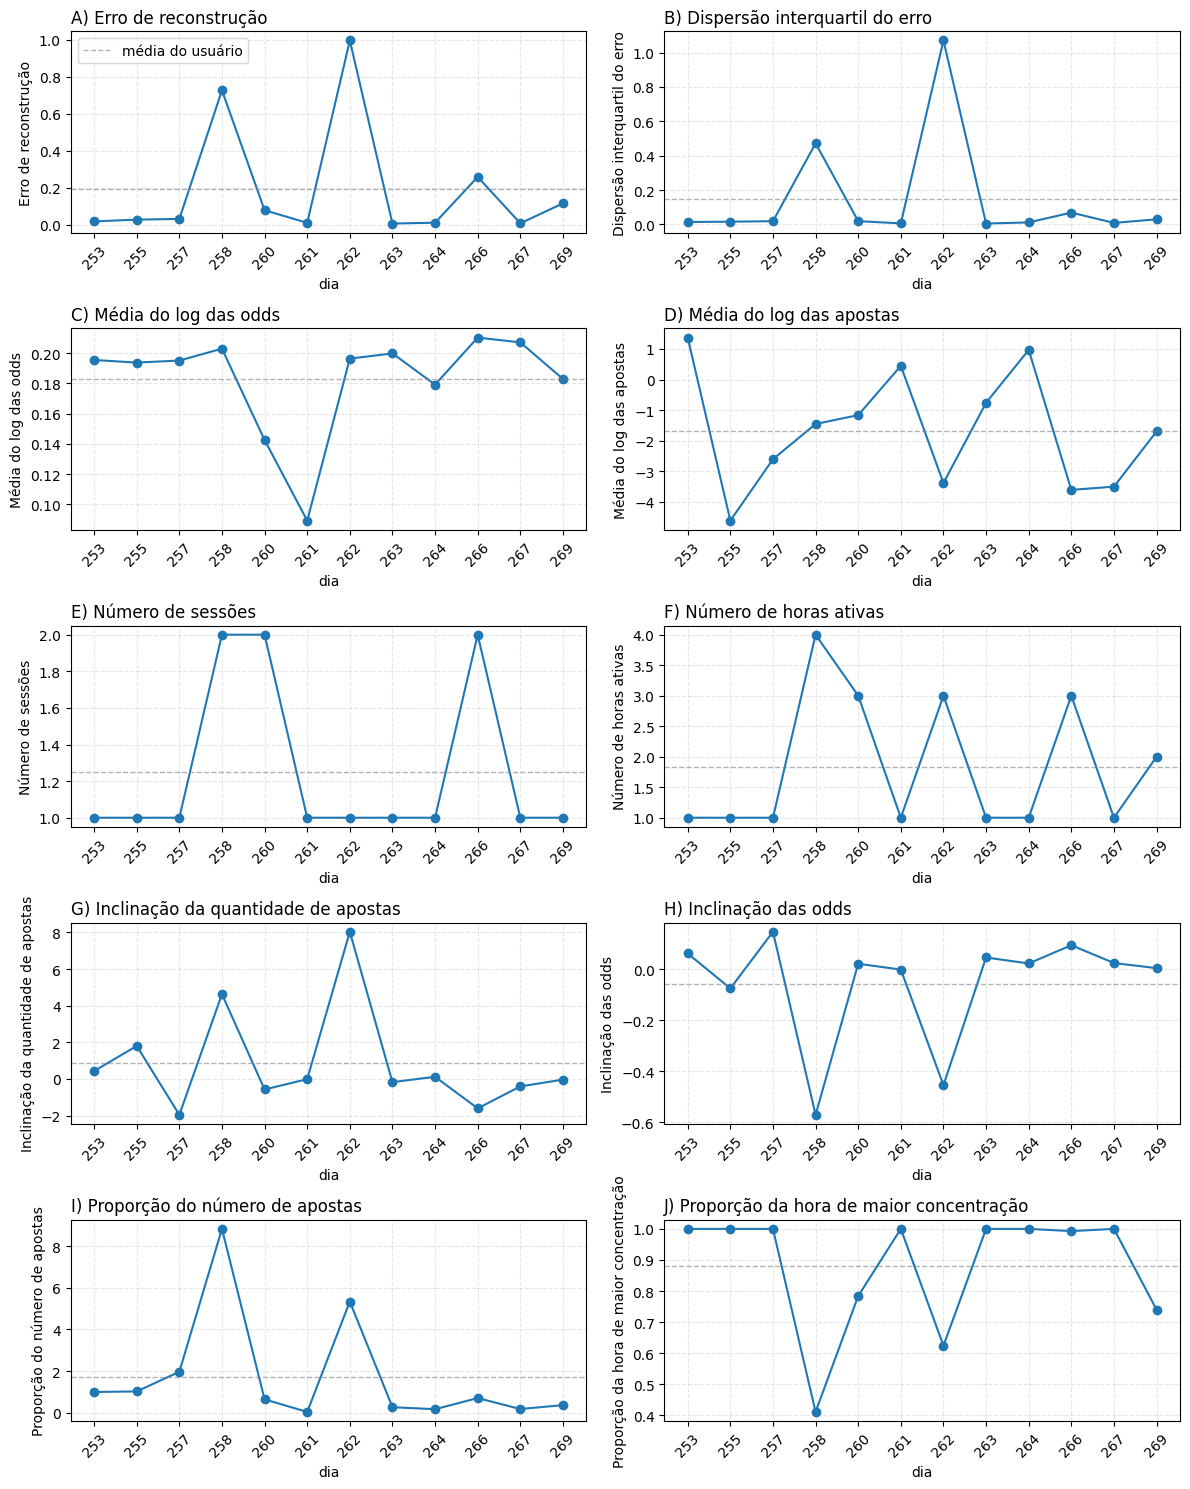

In [263]:
user_id = 1046423
plot_user_daily(recon_renamed, user_id=user_id, features=daily_feats, path_to_save=f'figs/user_{user_id}.pdf')


In [159]:
# day = 252
# plot_user_day_hourly(df=bets, user_id=user_id,day_of_year=day)
# day = 253
# plot_user_day_hourly(df=bets, user_id=user_id,day_of_year=day)
# day = 254
# plot_user_day_hourly(df=bets, user_id=user_id,day_of_year=day)



In [ ]:
plot_user_daily(recon_target, user_id=user_id, features=daily_feats)

plot_user_day_hourly(df=bets, user_id=user_id, day_of_year=day)



In [ ]:
hour = 13
plot_user_hour_bets(df=bets, user_id=user_id, day_of_year=day, hour=hour)


In [160]:
all_days = days.drop(columns=['user_id','day_of_year'])
all_days


,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970
...,...,...,...,...,...,...,...,...,...,...,...,...
130639,0.469348,0.309348,1.480713,2.308513,1.0,1,1.000000,1.000000,1.000000,-0.042490,-0.013468,1.000000
130640,0.192760,0.105671,2.745244,2.152429,1.0,1,1.000000,1.000000,1.000000,-0.064454,-0.004526,1.000000
130641,0.386987,0.334752,-8.095021,10.176622,1.0,1,1.000000,1.000000,1.000000,0.095029,-0.004543,1.000000
130642,0.165514,0.000000,0.000000,0.000000,1.0,1,1.000000,1.000000,1.000000,0.000000,-0.000648,1.000000


In [161]:
all_scaled = scaler.transform(all_days)
all_scaled[0]


array([-1.3602558 , -0.96073425,  0.37522426, -0.72563059, -0.41711495,
        0.37676417, -2.63472111,  0.19281784,  0.19281784,  0.00539622,
        0.02893782, -0.12624421])

In [164]:
all_tensor = torch.tensor(all_scaled, dtype=torch.float32).to(device)
all_tensor[0]


tensor([-1.3603, -0.9607,  0.3752, -0.7256, -0.4171,  0.3768, -2.6347,  0.1928,
         0.1928,  0.0054,  0.0289, -0.1262], device='cuda:0')

In [166]:
models[0]


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=12, bias=True)
  )
)

In [173]:
all_errors = []

for model in models:
    model.eval()
    with torch.no_grad():
        recon = model(all_tensor).cpu().numpy()

    err = ((all_scaled - recon) ** 2).mean(axis=1)
    all_errors.append(err)

all_errors = np.stack(all_errors, axis=0)


In [175]:
all_errors


array([[0.36368306, 0.06579773, 0.01567761, ..., 0.03793672, 0.00556648,
        0.00502161],
       [0.26834711, 0.04809342, 0.00785465, ..., 0.30029959, 0.00581402,
        0.005146  ],
       [0.35080363, 0.05155688, 0.00891549, ..., 0.16189359, 0.00692271,
        0.006297  ],
       ...,
       [0.52884153, 0.07121529, 0.03382582, ..., 0.01493555, 0.01152138,
        0.00950758],
       [0.49499837, 0.06522174, 0.00319592, ..., 0.3369978 , 0.00216503,
        0.00194495],
       [0.54135428, 0.06106552, 0.01510799, ..., 0.05606544, 0.00513631,
        0.003805  ]])

In [177]:
ensemble_error = np.median(all_errors, axis=0)
iqr = np.percentile(all_errors, 75, axis=0) - np.percentile(all_errors, 25, axis=0)


In [180]:
recon_df = days.copy()
recon_df["recon_error"] = ensemble_error
recon_df["iqr"] = iqr


In [181]:
recon_df.to_parquet('data/recon_df.parquet',engine='fastparquet')
recon_df = pd.read_parquet('data/recon_df.parquet',engine='fastparquet')


In [183]:
recon_df = recon_df.merge(labeled_users[['user_id','cluster_label']], how='left', on='user_id')


In [184]:
recon_df.groupby('cluster_label')['recon_error'].describe()


,count,mean,std,min,25%,50%,75%,max
cluster_label,,,,,,,,
0,71316.0,0.157110,0.789752,0.000692,0.008300,0.026031,0.134772,95.605943
1,20379.0,2.029661,6.244004,0.001523,0.154990,0.466519,1.524447,267.184775
2,1951.0,1.569309,7.875640,0.001385,0.010075,0.158408,0.799571,206.214456
3,30635.0,0.607686,1.978421,0.001027,0.039713,0.206560,0.512062,149.428695
4,5989.0,7.686838,12.897466,0.002068,0.757108,4.708752,11.023334,249.786236
5,374.0,11.259554,65.781319,0.001604,0.009625,0.211392,4.656591,1034.175740


In [ ]:
def get_cluster_colormap(clusters):
    # mesmo padrão que você já usa
    return {
        "0": "#f72585",
        "1": "#b5179e",
        "2": "#7209b7",
        "3": "#3a0ca3",
        "4": "#4361ee",
        "5": "#0883a8",
    }


def _sorted_clusters(series: pd.Series):
    s = series.astype(str)
    return sorted(s.unique(), key=lambda v: int(v) if v.lstrip("-").isdigit() else v)


def plot_recon_error_boxplot_by_cluster(
    df: pd.DataFrame,
    error_col: str = "recon_error",
    category_col: str = "cluster_label",
    log_y: bool = True,
    show_points: bool = True,
    sample_points: int | None = 8000,
    save_path: str | None = None
) -> None:
    """
    Boxplot do erro de reconstrução por cluster.
    - log_y: usa escala logarítmica no eixo Y (recomendado se há cauda longa)
    - show_points: sobrepõe pontos (amostrados) para mostrar densidade
    """

    X = df[[category_col, error_col]].copy()
    X[category_col] = X[category_col].astype(str)
    clusters = _sorted_clusters(X[category_col])
    color_map = get_cluster_colormap(clusters)

    data = [X.loc[X[category_col] == c, error_col].dropna().values for c in clusters]

    fig, ax = plt.subplots(figsize=(10, 6))

    bp = ax.boxplot(
        data,
        labels=[f"Cluster {c}" for c in clusters],
        showfliers=False,  # outliers extremos você ainda vai ver via log + pontos
        patch_artist=True
    )

    for patch, c in zip(bp["boxes"], clusters):
        patch.set_facecolor(color_map.get(c, "#888888"))
        patch.set_alpha(0.35)
        patch.set_edgecolor(color_map.get(c, "#888888"))
        patch.set_linewidth(1.2)

    for med, c in zip(bp["medians"], clusters):
        med.set_color(color_map.get(c, "#222222"))
        med.set_linewidth(2)

    if show_points:
        rng = np.random.default_rng(42)
        for i, c in enumerate(clusters, start=1):
            vals = X.loc[X[category_col] == c, error_col].dropna().values
            if sample_points is not None and len(vals) > sample_points:
                vals = rng.choice(vals, size=sample_points, replace=False)

            # jitter no x
            jitter = rng.normal(0, 0.06, size=len(vals))
            ax.scatter(
                np.full(len(vals), i) + jitter,
                vals,
                s=6,
                alpha=0.15,
                color=color_map.get(c, "#888888"),
                linewidths=0
            )

    if log_y:
        # evita problemas se houver zeros
        ymin = np.nanmin(X[error_col].values)
        if ymin <= 0:
            # coloca um limite inferior pequeno
            ax.set_yscale("log")
            ax.set_ylim(bottom=1e-8)
        else:
            ax.set_yscale("log")

    ax.set_xlabel("Clusters")
    ax.set_ylabel("Erro de reconstrução (mediana do ensemble - escala log)")
    # ax.set_title("Distribuição do erro de reconstrução por cluster" + (" (escala log)" if log_y else ""))

    ax.grid(True, which="both", axis="y", linestyle="--", alpha=0.25)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)

    plt.show()


def plot_recon_error_ecdf_by_cluster(
    df: pd.DataFrame,
    error_col: str = "recon_error",
    category_col: str = "cluster_label",
    log_x: bool = True,
    clip_min: float = 1e-8,
    save_path: str | None = None
) -> None:
    """
    ECDF do erro de reconstrução por cluster (0% -> 100%).
    - log_x: usa escala log no eixo X (recomendado se a cauda é grande)
    - clip_min: evita log(0) quando houver erros 0 (clipa no mínimo)
    """

    X = df[[category_col, error_col]].copy()
    X[category_col] = X[category_col].astype(str)
    clusters = _sorted_clusters(X[category_col])
    color_map = get_cluster_colormap(clusters)

    fig, ax = plt.subplots(figsize=(10, 6))

    for c in clusters:
        vals = X.loc[X[category_col] == c, error_col].dropna().values
        if len(vals) == 0:
            continue

        if log_x:
            vals = np.clip(vals, clip_min, None)

        vals = np.sort(vals)
        y = np.arange(1, len(vals) + 1) / len(vals)

        ax.plot(vals, y, label=f"Cluster {c}", color=color_map.get(c, "#888888"), linewidth=2, alpha=0.9)

    if log_x:
        ax.set_xscale("log")

    ax.set_xlabel("Erro de reconstrução (mediana do ensemble)" + (" (escala log)" if log_x else ""))
    ax.set_ylabel("Proporção acumulada (ECDF)")
    # ax.set_title("Distribuição acumulada do erro de reconstrução (ECDF) por cluster")
    ax.set_ylim(0, 1.0)

    ax.grid(True, which="both", axis="both", linestyle="--", alpha=0.25)
    ax.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)

    plt.show()


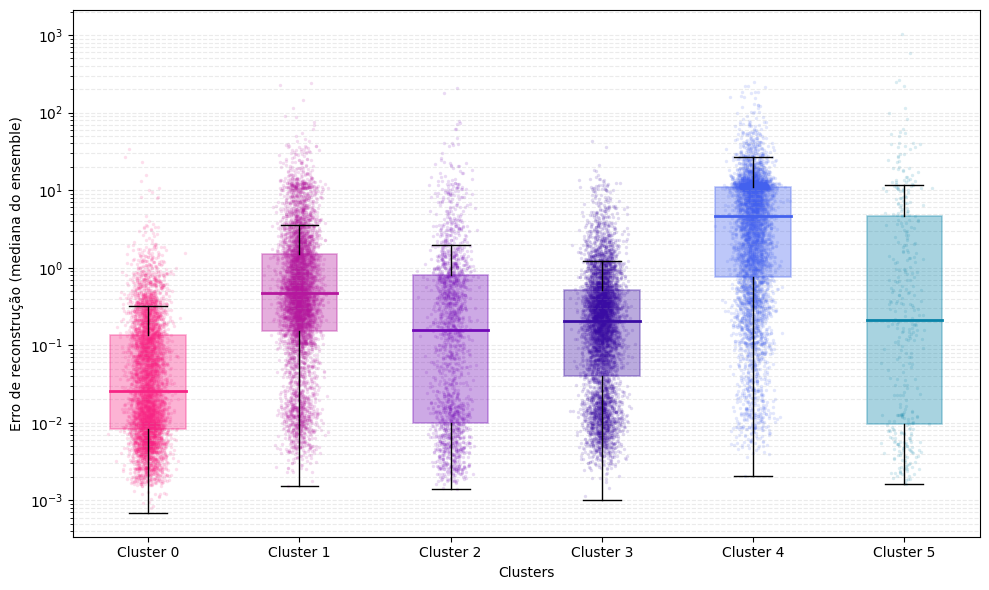

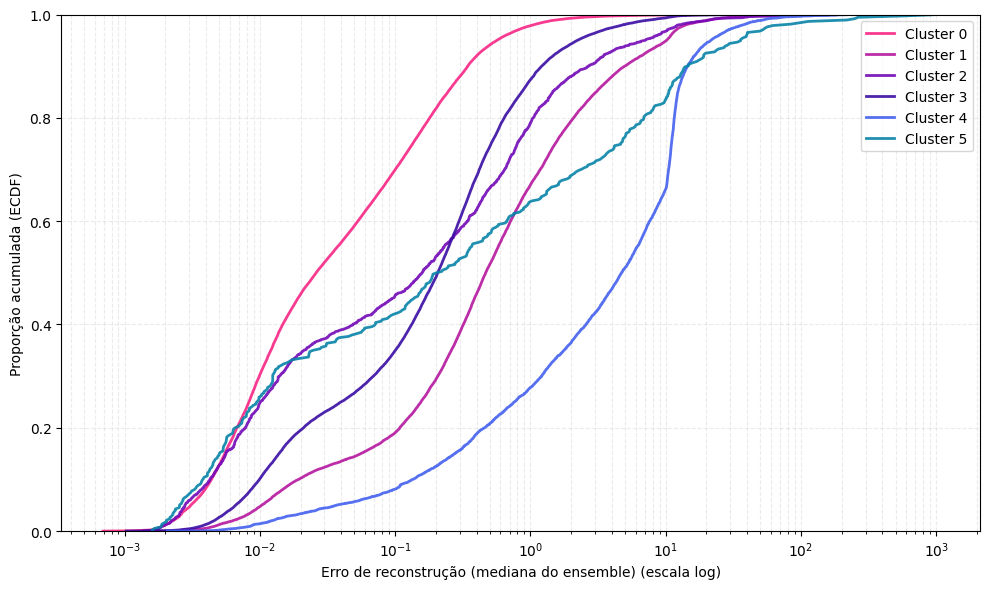

In [196]:
plot_recon_error_boxplot_by_cluster(
    recon_df,
    error_col="recon_error",
    category_col="cluster_label",
    log_y=True,
    show_points=True,
    sample_points=6000,
    save_path='figs/p10.pdf'
)

plot_recon_error_ecdf_by_cluster(
    recon_df,
    error_col="recon_error",
    category_col="cluster_label",
    log_x=True,
    save_path='figs/p11.pdf'
)


In [ ]:
threshold = recon_df.loc[
    recon_df["cluster_label"] == 0,
    "recon_error"
].quantile(0.95)
threshold


0.5652618702922287

In [198]:
recon_df["is_atypical"] = recon_df["recon_error"] > threshold


In [ ]:
recon_df


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,iqr,cluster_label,is_atypical
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000,0.363683,0.202345,0,False
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667,0.061066,0.015685,0,False
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500,0.008915,0.007589,0,False
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282,0.398369,0.102533,0,False
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970,0.160427,0.021739,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130639,1503508,274,0.469348,0.309348,1.480713,2.308513,1.0,1,1.000000,1.000000,1.000000,-0.042490,-0.013468,1.000000,0.005639,0.005369,0,False
130640,1503513,274,0.192760,0.105671,2.745244,2.152429,1.0,1,1.000000,1.000000,1.000000,-0.064454,-0.004526,1.000000,0.008782,0.026397,0,False
130641,1503516,274,0.386987,0.334752,-8.095021,10.176622,1.0,1,1.000000,1.000000,1.000000,0.095029,-0.004543,1.000000,0.056065,0.187041,0,False
130642,1503542,274,0.165514,0.000000,0.000000,0.000000,1.0,1,1.000000,1.000000,1.000000,0.000000,-0.000648,1.000000,0.005566,0.001964,0,False


In [257]:
user_atypical = (
    recon_df
    .groupby("user_id")
    .agg(
        n_days=("recon_error", "count"),
        n_atypical_days=("is_atypical", "sum"),
        frac_atypical_days=("is_atypical", "mean"),
        error_mean=("recon_error", "mean"),
        error_std=("recon_error", "std"),
        iqr_mean=("iqr", "mean"),
        iqr_std=("iqr", "std"),
        cluster_label=("cluster_label", "first"),
    )
    .reset_index()
)

candidates = user_atypical[
    (user_atypical["n_days"] >= 5) &
    (user_atypical["n_atypical_days"] >= 3) &
    (user_atypical["frac_atypical_days"] <= 0.2)
]


C:\Users\mathe\AppData\Local\Temp\ipykernel_3152\2550304321.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("user_id")


In [271]:
candidates = user_atypical[
    (user_atypical["n_days"] >= 5) &
    (user_atypical["n_atypical_days"] >= 3) &
    (user_atypical["frac_atypical_days"] == 0.2)
]


candidates.sort_values(by=['error_mean',], ascending=False).head(10)


,user_id,n_days,n_atypical_days,frac_atypical_days,error_mean,error_std,iqr_mean,iqr_std,cluster_label
11561,1288121,20,4,0.2,2.735936,8.596153,0.611842,1.726305,4
6819,1032342,20,4,0.2,2.451389,6.538727,1.206334,4.070990,0
8110,1155938,15,3,0.2,1.469257,3.076505,0.972542,2.269158,3
1532,339431,15,3,0.2,1.453996,3.557846,2.297450,5.730047,0
3583,723086,15,3,0.2,0.689405,1.616630,0.258035,0.496545,0
5245,933417,15,3,0.2,0.544252,0.814336,0.391915,0.303614,3
5316,939851,20,4,0.2,0.528398,0.708385,0.210331,0.234818,3
15176,1378441,20,4,0.2,0.498540,0.540034,0.172815,0.124414,1
1058,224141,20,4,0.2,0.491229,0.653792,0.300297,0.383474,3
8663,1179787,15,3,0.2,0.470531,0.912066,0.378801,0.811374,4


In [269]:
candidates = user_atypical[
    (user_atypical["n_days"] >= 5) &
    (user_atypical["n_atypical_days"] >= 3) &
    (user_atypical["frac_atypical_days"] == 0.5)
]
candidates.sort_values(by=['error_mean',], ascending=False).head(10)


,user_id,n_days,n_atypical_days,frac_atypical_days,error_mean,error_std,iqr_mean,iqr_std,cluster_label
1037,220550,18,9,0.5,11.646932,23.049861,5.581926,15.077696,1
12274,1309287,20,10,0.5,11.553435,39.232353,253.368969,1124.062802,2
15617,1387744,6,3,0.5,11.390255,21.962729,4.978019,8.964251,1
15264,1380472,6,3,0.5,10.754444,17.315817,6.978562,12.027292,1
20537,1441090,6,3,0.5,10.037047,22.506297,6.722001,15.679400,4
4085,782485,6,3,0.5,8.786651,13.163823,5.718162,8.777773,1
8202,1160973,8,4,0.5,6.823394,17.689557,5.192784,14.271888,1
362,113243,18,9,0.5,6.483291,16.690508,4.276450,11.916362,1
14207,1357121,20,10,0.5,6.207878,6.944704,1.364919,1.971315,0
5093,923623,16,8,0.5,5.545513,7.897507,2.754739,5.114967,1


In [227]:
recon_renamed = recon_df.rename(columns={'recon_error':'Erro de reconstrução',
                             'n_active_hours':'Número de horas ativas',
                             'n_sessions':'Número de sessões',
                             'n_bet_proportion':'Proporção do número de apostas',
                             'slope_bet_day':'Inclinação da quantidade de apostas',
                             'slope_odd_day':'Inclinação das odds',
                             'odds_log_mean':'Média do log das odds',
                             'iqr':'Dispersão interquartil do erro',
                             'bet_prop_log_mean':'Média do log das apostas',
                            #  'bet_prop_log_std':'Desvio Padrão do log das apostas',
                            #  'odds_log_std':'Desvio Padrão do log das odds',
                             'bet_top1hour%':'Proporção da hora de maior concentração',
                             })


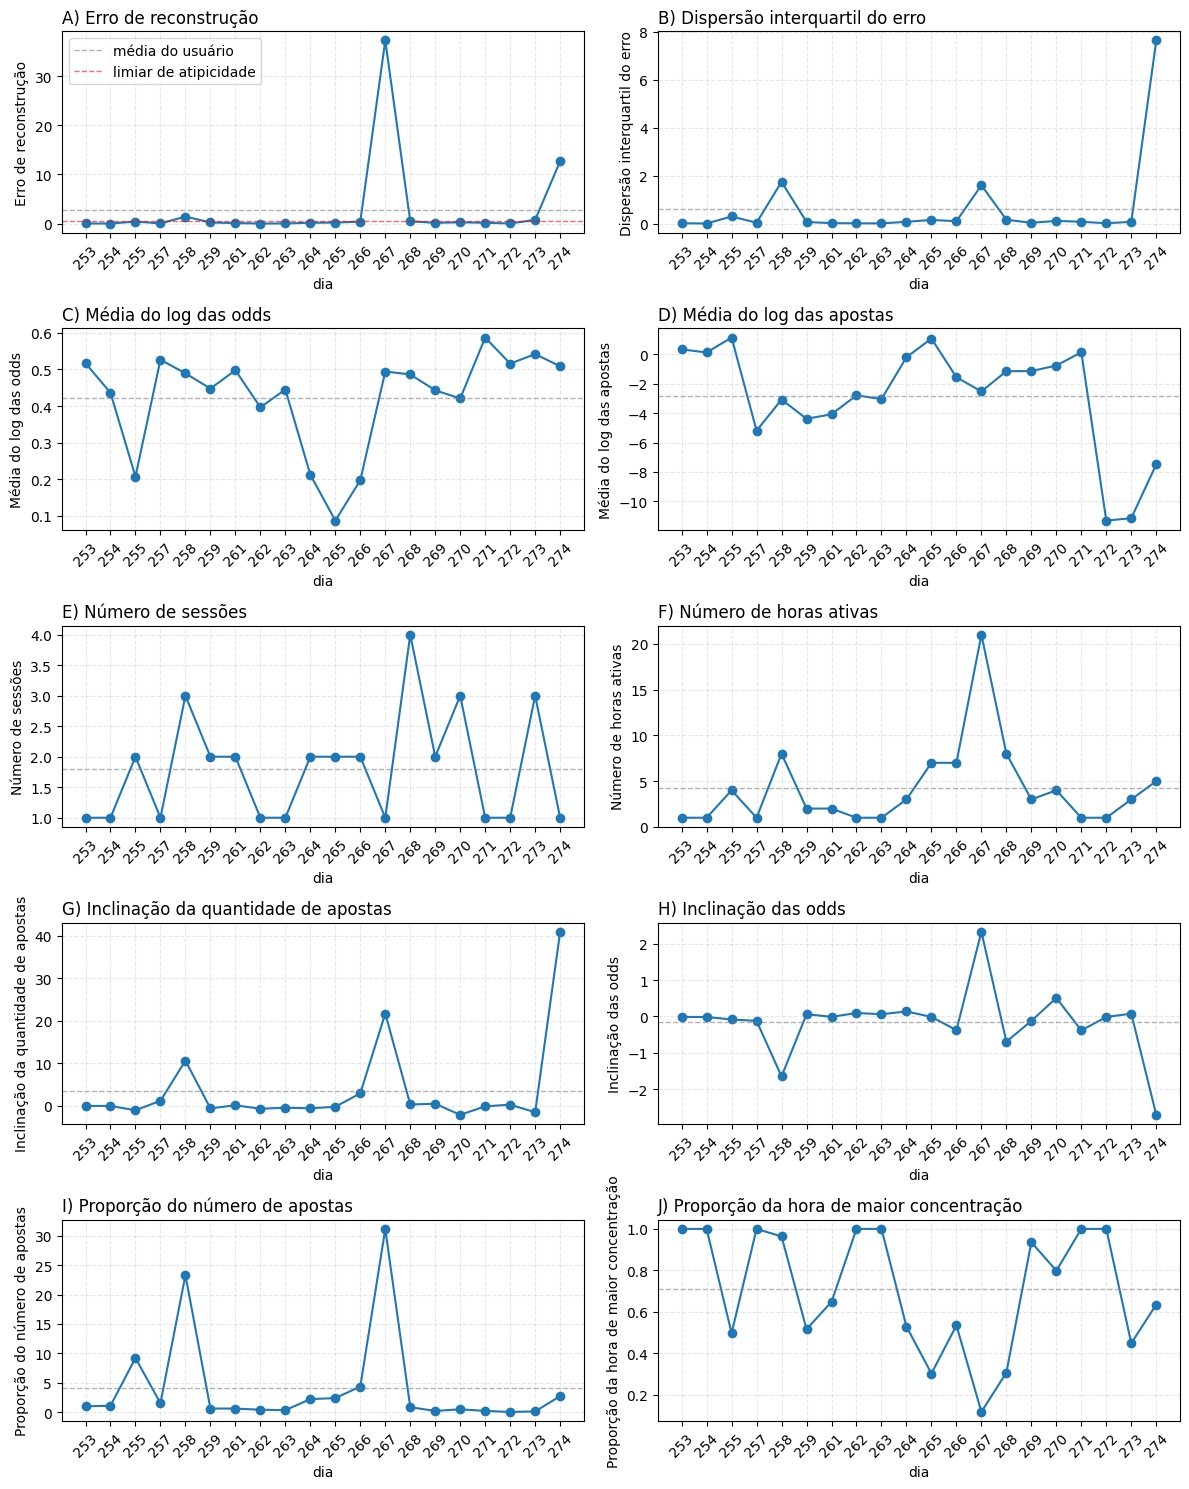

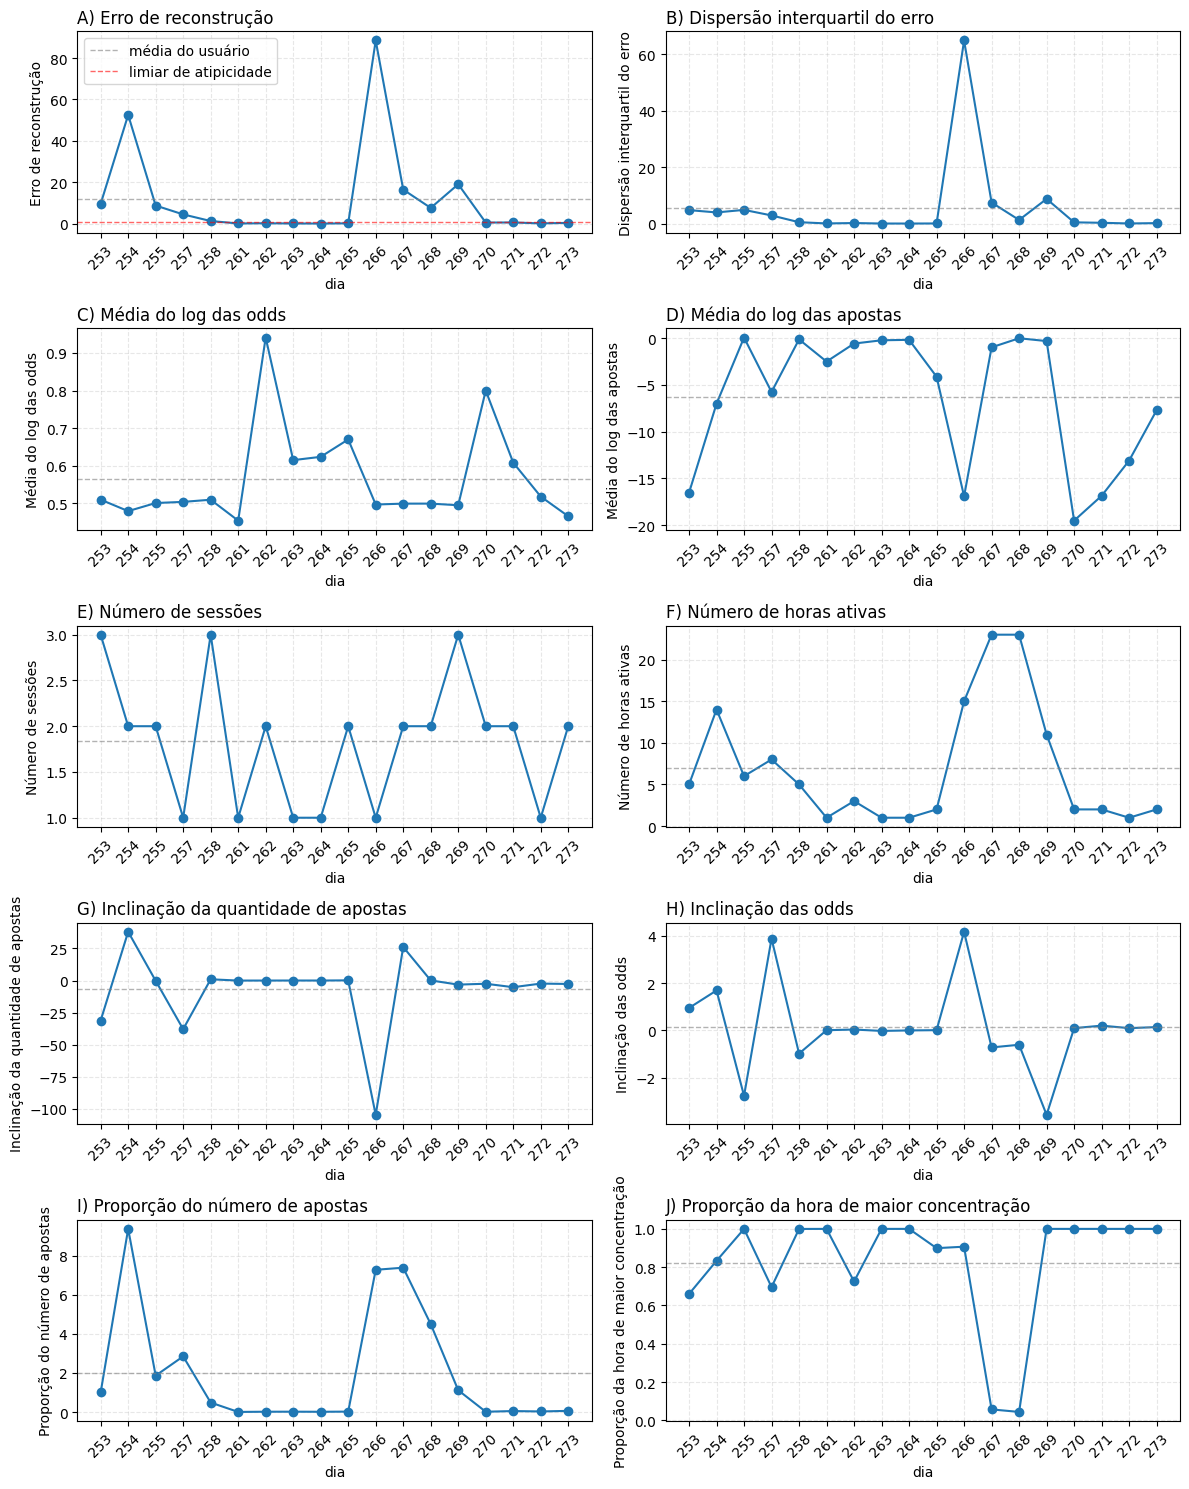

In [274]:


user_id = 1288121
plot_user_daily(recon_renamed, user_id=user_id, features=daily_feats,path_to_save=f'figs/user_{user_id}.pdf', threshold=threshold)      

user_id = 220550
plot_user_daily(recon_renamed, user_id=user_id, features=daily_feats,path_to_save=f'figs/user_{user_id}.pdf', threshold=threshold)


In [273]:



# user_id = 1280963
# plot_user_daily(recon_renamed, user_id=user_id, features=daily_feats, threshold=threshold)
# user_id = 1040342
# plot_user_daily(recon_renamed, user_id=user_id, features=daily_feats, path_to_save=f'figs/user_{user_id}.pdf', threshold=threshold)


In [32]:
recon_df[recon_df['cluster_label'] == 1].sort_values(by='recon_error', ascending=False).head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,cluster_label
75583,1338836,260,1.540842,0.996576,-0.655833,1.176517,1.0,24,0.084803,0.162501,0.162501,-11.449120,16.611532,2.106065,245.855279,1
55123,1225103,253,1.336099,0.883252,-0.366022,1.029961,3.0,9,0.191581,0.350316,0.350316,-4.014474,15.320982,1.000000,227.328294,1
4270,180754,261,1.220017,0.829870,-0.075421,0.423897,4.0,8,0.224221,0.430146,0.430146,0.501276,-12.674580,1.487723,156.532980,1
73596,1329183,261,1.843722,0.727841,-1.888593,2.004851,2.0,23,0.140317,0.276078,0.276078,-7.538863,12.590584,2.642288,147.892221,1
2331,115814,272,0.223014,0.234688,-15.178456,6.243322,3.0,13,0.849840,0.914918,0.914918,-87.680397,0.401351,11.000265,139.664025,1


In [180]:
recon_df.sort_values(by='recon_error', ascending=True).head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,...,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion,recon_error,cluster_label
107203,1441962,264,0.058069,0.02304,1.198114,0.030024,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.035422,-0.001717,0.584795,0.000317,0
114233,1455722,266,0.000000,0.00000,1.106385,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.009140,0.000000,0.526316,0.000335,0
17167,564919,256,0.039221,0.00000,0.716956,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.005299,-0.000290,0.526316,0.000340,0
27868,906284,258,0.009950,0.00000,1.175546,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.000511,-0.000004,0.500000,0.000359,0
17166,564919,255,0.000000,0.00000,1.290478,0.000000,1.0,1,1.0,1.0,...,0.079861,1.0,1.0,1.0,0.079861,-0.007294,0.000000,0.500000,0.000365,0


In [33]:
user_error = (recon_df.groupby(['user_id'], observed=True)
                .agg(
                    error_mean=('recon_error','mean'),
                    error_std=('recon_error','std'),
                    
                    cluster_label=('cluster_label','first'),
                    
                    n_days=('day_of_year','nunique'),
                    n_hours=('n_active_hours','sum'),
                )
                .fillna(0.0)
                .astype('float32'))


In [34]:
user_error.sort_values(by='error_mean', ascending=False).head(30)


,error_mean,error_std,cluster_label,n_days,n_hours
user_id,,,,,
398976,151.023438,132.234619,4.0,3.0,16.0
1189711,104.133583,204.020447,5.0,5.0,50.0
935139,57.725971,81.632393,5.0,2.0,9.0
967686,52.812439,106.487877,5.0,6.0,58.0
369102,41.557991,48.369892,4.0,18.0,377.0
1457607,41.230545,69.459351,4.0,6.0,78.0
1338836,40.225388,61.244453,1.0,19.0,254.0
1027616,35.647694,45.427193,4.0,20.0,402.0
1183621,34.761589,21.492159,4.0,2.0,35.0


In [41]:
user_id = 1329183
day = 261
hour = 13



In [185]:

# plot_user_daily(recon_df, user_id=user_id, features=daily_feats)
# plot_user_day_hourly(
#     df=bets,          
#     user_id=user_id,
#     day_of_year=day  
# )
# plot_user_hour_bets(
#     df=bets,          
#     user_id=user_id,
#     day_of_year=day,   
#     hour=hour  
# )
